In [2]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt
from matplotlib import figure 
import os
import glob
import time

# Part 1

This section contains multiple parts.
- Algorithm 1 which uses vector calculations and checks every  pixel on a line

- Algorithm 2 which uses vector calculations but only checks pixels to the left of a pixel we are trying to match 

Algorithm 1 was developed using SSD, with plans to implement NCC at a later stage. Algorithm 2 uses both SSD and NCC.

Note that in the report we discuss a simple version that loops through every pixel in the right line and how it is too slow. This is illustrated in the results section after part 2.

Additionally, the algorithms were developed to handle variable sized inputs, but have since been modified to just suit our test data with shape (400,881,3). Thus you will see the number 881 in the implmentations as it makes the algorithms easier to understand (There will be a comment next to the first '881' showing how we handled multiple sized inputs).

Lastly, ws_component is not the window size, but is similar to a radius. For example, a ws_component = 1 gives us a window size of (2*ws_component + 1) = 3  

**Vectorised Version 1**

In [2]:
## ws stand for window size, window size component 
def img_disparity(img_left, img_right, ws_component):

    img_left = cv2.copyMakeBorder(img_left, ws_component, ws_component, ws_component, ws_component, cv2.BORDER_CONSTANT, None, value = 0)
    img_right = cv2.copyMakeBorder(img_right, ws_component, ws_component, ws_component, ws_component, cv2.BORDER_CONSTANT, None, value = 0)

    x = img_left.shape[1] 
    y = img_left.shape[0]

    print(y)
    print(x)

    disparity = []

    for i_y in range(ws_component, y-ws_component):

        if(i_y % 100 == 0):
            print("On i_y ", i_y) ## Just to help you keep track of progress
        
        right_line_nbhds = []

        ## Calculate all the pixel neighbourhoods for the row in the right image
        for i_x2 in range(ws_component, x-ws_component):
            nbhd_right_img = np.array(img_right[i_y-ws_component:i_y+ws_component+1, i_x2-ws_component:i_x2+ws_component+1,:]).astype(int).flatten() ##.reshape(1,window_size**2)
            right_line_nbhds.append(nbhd_right_img)

        ## Note that the '881' here (and in the rest of the code) was initially (x - 2*ws_componet)
        right_line_nbhds = np.array(right_line_nbhds).flatten()
        right_line_nbhds = np.tile(right_line_nbhds, 881) ## This replicates the right neighbourhoods

        left_line_nbhds = []

        ## Calculate all pixel neighbourhoods for the row in the right image
        for i_x2 in range (ws_component, x - ws_component):

            nbhd_left_img = np.array(img_left[i_y-ws_component:i_y+ws_component+1, i_x2-ws_component:i_x2+ws_component+1,:]).astype(int).flatten()
            nbhd_left_img = np.tile(nbhd_left_img, 881) ## Replicate that specific nbhd by the amount of pixels we consider in a row
            left_line_nbhds.append(nbhd_left_img)


        left_line_nbhds = np.array(left_line_nbhds).flatten()

        diffsquared = ((left_line_nbhds-right_line_nbhds)**2)

        step = ((2*ws_component+1)**2)*3 ## Number of pixels in window * number of colour channels(3)

        ssds = np.array([diffsquared[i:i+step].sum() for i in range(0,len(diffsquared), step )] ) ## Sums the squared difference for intervals of length step 

        ## Note that this returns this first match with lowest SSD it finds (scanning left to right)
        min_ssd = np.array([np.argmin(ssds[i:i + 881]) for i in range (0, 881**2, 881 )])

        ## This should be the np.linspace(vars) - min_ssd, however experiments were run with this, and it is corrected in the next algorithm 
        row_disparity = min_ssd - np.linspace(0, x - (2*ws_component + 1) ,num = 881).astype(int)

        disparity.append(row_disparity)
    
            
    return disparity

**Vectorised Version 2**

In [3]:

## Note this function takes flattened numpy arrays
def ssd(left_array, right_array, ws_component):

    step = ((2*ws_component+1)**2)*3 ## Number of pixels in window * number of colour channels(3)
    dif_squared = ((left_array - right_array)**2)

    ssds = np.array([dif_squared[i:i+step].sum() for i in range(0,len(dif_squared), step )] )

    return ssds

##Note that the arrays that are fed into this need to flattened numpy arrays
## requires more computation so is slower 
def ncc(left_array, right_array, ws_component):

    step = ((2*ws_component+1)**2)*3

    product = (left_array * right_array)

    left_squared = left_array**2
    right_squared = right_array**2

    nccs = np.array(   [ product[i:i+step].sum()/ ( np.sqrt(left_squared[i:i+step].sum()) * np.sqrt(right_squared[i:i+step].sum()) ) for i in range(0,len(product),step ) ]  )  
    
    return nccs
    

## This function returns an index for a match that has the best similarity measure (NCC or SSD) and is closest to a specific index
def return_closest(array, index_tobeclose2, match_func):

    if match_func == ssd:

        index_closest = np.argmax( ( np.where(array == array.min() )[0]) - index_tobeclose2  ) 
        pre_output = np.where(array == array.min())[0]
    else:
        
        index_closest = np.argmax( ( np.where(array == array.max() )[0]) - index_tobeclose2  ) 
        pre_output = np.where(array == array.max())[0]


    output = pre_output[index_closest]

    return output 



## ws stand for window size, window size component 
def img_disparityv2(img_left, img_right, ws_component, matching_function = ssd , gaus_kernel = False):

    img_left = cv2.copyMakeBorder(img_left, ws_component, ws_component, ws_component, ws_component, cv2.BORDER_CONSTANT, None, value = 0)
    img_right = cv2.copyMakeBorder(img_right, ws_component, ws_component, ws_component, ws_component, cv2.BORDER_CONSTANT, None, value = 0)

    x = img_left.shape[1] 
    y = img_left.shape[0]

    ## Generate a 2D gaussian kernel which is used to weight the neighbourhoods if gaus_kernel = True
    gaus_k = cv2.getGaussianKernel((2*ws_component+1),1)
    gausk_2d = gaus_k@gaus_k.T
    gausk_2d = np.repeat(gausk_2d,3) ##repeats each element 3 times in place so it can be applied to the value of each colour channel 


    disparity = []


    for i_y in range(ws_component, y-ws_component):

        if(i_y % 50 == 0):
            print("On i_y ", i_y) ## Just to help you keep track of progress


        right_line_nbhds = []

        ## Calculate all the pixel neighbourhoods for the row in the right image. Note that the right image neighbourhoods 
        ## to the left of the left image pixel are the only neighbourhoods generated
        for i_x2 in range(ws_component, x-ws_component):

            nbhd_right_img = np.array(img_right[i_y-ws_component:i_y+ws_component+1, i_x2-ws_component:i_x2+ws_component+1,:]).astype(int).flatten() ##.reshape(1,window_size**2)
            
            if gaus_kernel:
                nbhd_right_img = nbhd_right_img*gausk_2d
            
            right_line_nbhds.append(nbhd_right_img)

        right_line_nbhds = np.array([np.array(right_line_nbhds[0:i]).flatten() for i in range(1,881+1)]) ## Generates r nbhds vector. See report for details
        right_line_nbhds = np.hstack(right_line_nbhds) ## Flatten but for variable an array of arrays with different lengths

        left_line_nbhds = []

        ## Generate all left image neighbourhoods 
        for i_x2 in range (ws_component, x - ws_component):

            nbhd_left_img = np.array(img_left[i_y-ws_component:i_y+ws_component+1, i_x2-ws_component:i_x2+ws_component+1,:]).astype(int).flatten()

            if gaus_kernel:
                nbhd_left_img = nbhd_left_img*gausk_2d
            
            nbhd_left_img = np.tile(nbhd_left_img, i_x2 - ws_component + 1) ## Tiles a nbhd based on its horizontal position. See report for details
            left_line_nbhds.append(nbhd_left_img)


        left_line_nbhds = np.hstack(np.array(left_line_nbhds))

        mf_results = matching_function(left_line_nbhds,right_line_nbhds, ws_component) ## Returns matching function results for every neighbourhood

        ## This is how we group the neighbourhoods to compare. For example we only want to compare the first left neighbourhood with the 
        ## first right neighbourhood, then the second left neighbourhood with first and second right neighbourhoods
        ## so we end up with a sequence like [0,1,3,6,10,15] and if you take [0,1] that gives you the indices of our neighbourhood vector which 
        ## compare the left most neighbourhoods between the two pictures, then we take the [1,3] which allows you to compare the the 2nd left neighbourhood
        ## with the 1st and second right neighbourhoods. See the report for the structure of our neighbourhood vectors. 
        groupings = [ (i**2)/2 - i/2 for i in range (1,883)] ## I had to use the quadratic formula to solve this, haha! 


        best_matches = [ return_closest(mf_results[int(groupings[i]):int(groupings[i+1])], i, matching_function) for i in range (0,881)] 


        row_disparityv4 = np.linspace(0, 880 ,num = 881).astype(int) - best_matches 

        disparity.append(row_disparityv4)
    
            
    return disparity



# Part 2

Functions to calculate the per-pixel error, the rms error, and the fractions of pixels with less than 4, 2, 1, and 0.25 pixels error.
All of the statistic function use get_dif in their implementation, so you don't need to call it first.

In [1]:
import numpy as np
ERROR_SHAPE_MISMATCH = -1

In [2]:
def get_dif(disp_calc, disp_truth):
    """
    Gets the difference in pixels between the calculated and ground disparity maps
    Assumes the ground is in units of 256*pixels, and the calculated is in pixels
    Returns the difference as a 2d array of same shape is its inputs, as well as an index representing the non-zero values
    """
    # Make sure the images are the same size
    if (disp_calc.shape != disp_truth.shape):
        print("ERROR! The disparity map and the ground truth have differenct sizes")
        return ERROR_SHAPE_MISMATCH, ERROR_SHAPE_MISMATCH
    # Get the indices of the nonzero values
    non_zero   = np.nonzero(disp_truth)
    difference = disp_truth.copy()/256
    # Get the differences
    difference[non_zero] = difference[non_zero] - disp_calc[non_zero]
    difference = np.abs(difference)
    
    return difference, non_zero

In [3]:
a = np.eye(10)

In [4]:
b = np.eye(10)*128

In [5]:
get_dif(a,b)

(array([[0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5]]),
 (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
  array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)))

In [6]:
def rms(disp_calc, disp_truth):
    """
    Given a calculated and a ground disparity map, computes the rms between them
    """
    difference, non_zero = get_dif(disp_calc, disp_truth)
    error         = np.sqrt(np.mean(difference[non_zero].flatten()**2))
    return error

In [7]:
rms(a,b)

0.5

In [8]:
def fractions(disp_calc, disp_truth):
    """
    Given a calculated and a ground disparity map, computes the 
    fractions of pixels with less than 4, 2, 1, and 0.25 pixels error
    """
    difference, non_zero = get_dif(disp_calc, disp_truth)
    difs      = difference[non_zero].flatten()
    fracs     = [4,2,1,0.5,0.25]
    frac_dict = {}
    # Calculate the fractions
    for frac in fracs:
        frac_dict[frac] = len(difs[difs<frac])/len(difs)
        
    return frac_dict

In [9]:
fractions(a,b)

{4: 1.0, 2: 1.0, 1: 1.0, 0.5: 0.0, 0.25: 0.0}

Now we wrap all of this up into one function

In [10]:
def get_stats(disp_calc, disp_truth):
    return rms(disp_calc, disp_truth), fractions(disp_calc, disp_truth)

Results 
---

This section also illustrates how looping (our initial implmentation) drove us to create a vectorized implementation. 

Additionally, the two approaches used for part 1 are not run in this file, but rather their outputs are displayed. This is because the experiements were run in a different file over over multiple days , and all runtimes were noted (As displayed in the report)

**Showing how looping approach is not suitable for experimentation**

In [37]:

def ssdloop(vecs1, vecs2, window_size):

    vecs1 = vecs1.flatten().reshape((2*window_size+1)**2, 3).astype(int)
    vecs2 = vecs2.flatten().reshape((2*window_size+1)**2, 3).astype(int)

    
    output = np.sum([np.sum((x)**2) for x in (vecs1-vecs2)])

    return output


base_path  = os.getcwd() + "/Dataset/"
pathL = '2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg'
pathR = '2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg'

print(base_path + pathL)

window_size = 1 ## This is not the size of the actual window, our window looks like this [window_size :pixel of interest: window_size], so the size of the whole window is (2*window size)+1

left = cv2.imread(base_path + pathL)
right = cv2.imread(base_path + pathR)

# print("Shape before padding ", left.shape)
# print("Shape before padding ", right.shape)

left = cv2.copyMakeBorder(left, window_size, window_size, window_size, window_size, cv2.BORDER_CONSTANT, None, value = 0)
right = cv2.copyMakeBorder(right, window_size, window_size, window_size, window_size, cv2.BORDER_CONSTANT, None, value = 0)

# print("Shape after padding ", left.shape)
# print("Shape after padding ", right.shape)

x = left.shape[1] 
y = left.shape[0]

disparity = []

for i_y in range(1,2):

    # print(i_y-window_size)


    right_line_nbhds = []

    print("Before right x nbhds created")

    ## Create all the pixel neighbourhoods for the line in the right image
    for i_x2 in range(window_size, x-window_size):
            
        nbhd_right_img = np.array(right[i_y-window_size:i_y+window_size+1, i_x2-window_size:i_x2+window_size+1,:]).astype(int) 
        right_line_nbhds.append(nbhd_right_img)

    print("After right x nbhds created")
    right_line_nbhds = np.array(right_line_nbhds)
    # print(len(right_line_nbhds))

    print("nbhds ",len(right_line_nbhds))
    ## For each x in the left image, compare it to every pixel neighbourhood in the right image (using SSD here) and take the smallest SSD
    for i_x in range(window_size, x-window_size):

        # print(i_x)
        
        x_left = left[i_y-window_size:i_y + window_size + 1,i_x - window_size:i_x+window_size+1,:] ## Left pixel neighbourhood
        nbhd_ssd = np.array([ssdloop(x_left,r, window_size) for r in right_line_nbhds]) ## Generate all SSDs for left pixel (1 per right pixel nbhd) 
        match_r_img = np.argmin(nbhd_ssd) ## Take minimum ssd as the closest match       
        pixel_disparity = (i_x - window_size) - match_r_img ## Calculate disparity


        disparity.append(pixel_disparity)




/Users/oliverbestel/Desktop/Documents/Work/COMP90086/Tuts/P1/CV_Project/Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg
Shape before padding  (400, 881, 3)
Shape before padding  (400, 881, 3)
Shape after padding  (402, 883, 3)
Shape after padding  (402, 883, 3)
Before right x nbhds created
After right x nbhds created
nbhds  881


**Dispaying Results** 

note that we will only display the results for image 23 to illustrate the our experimentation (with options to display imgages 24 and 25 too)

- The same transform that was applied to the true disparity map will be applied to our result that gives the best stats
- Gaussian weighting of neighbourhoods was tested on image 23

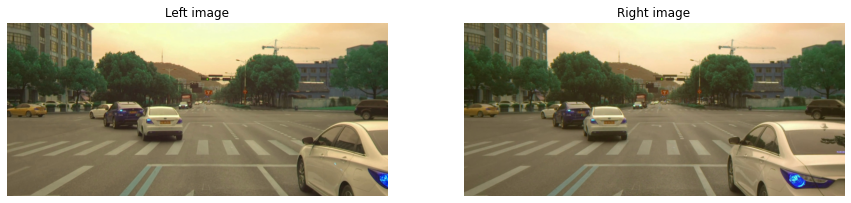

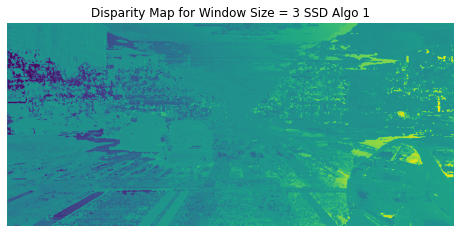

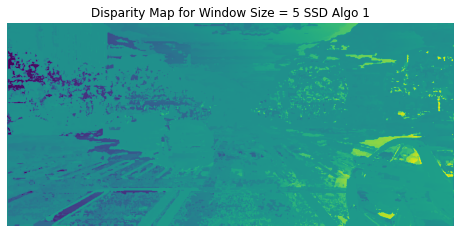

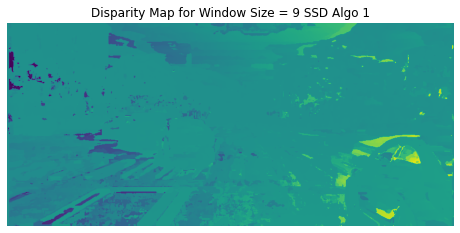

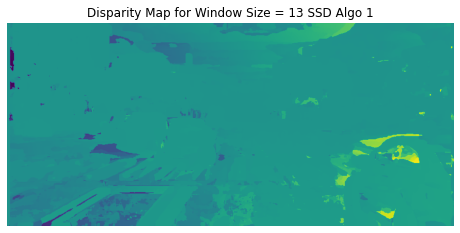

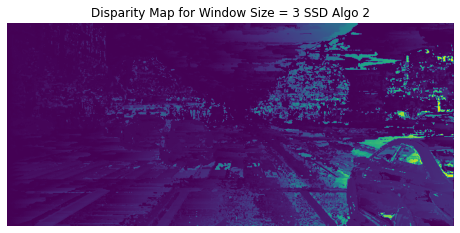

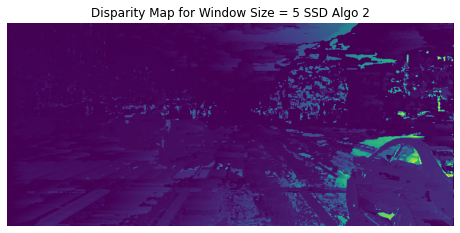

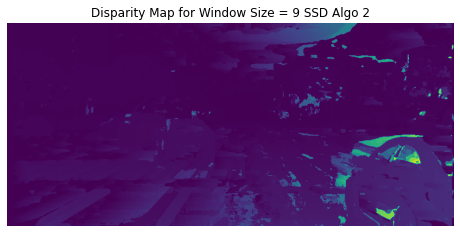

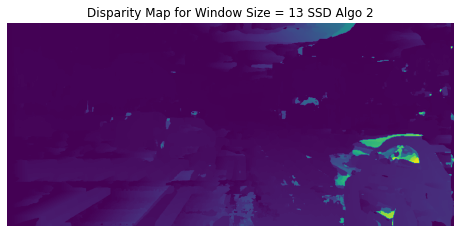

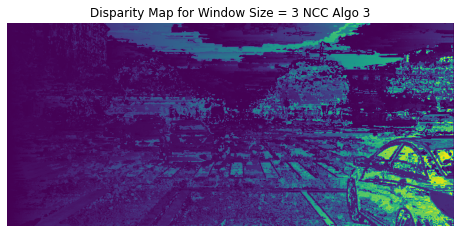

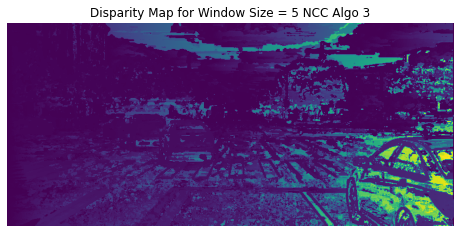

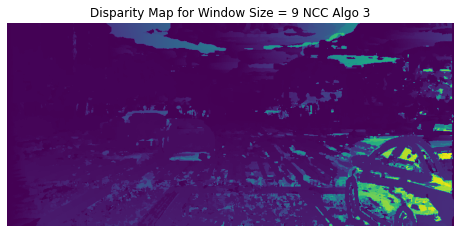

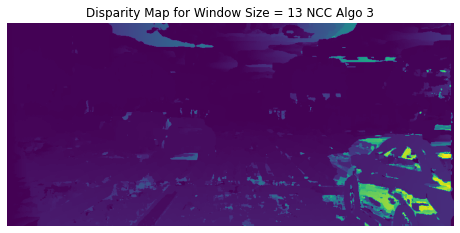

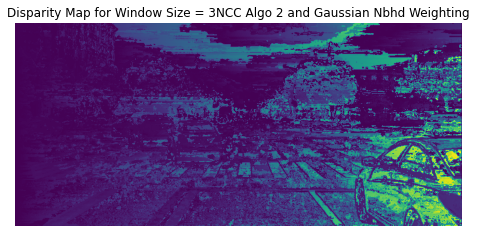

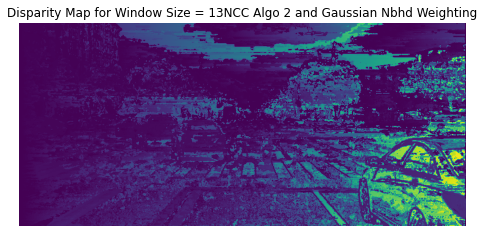

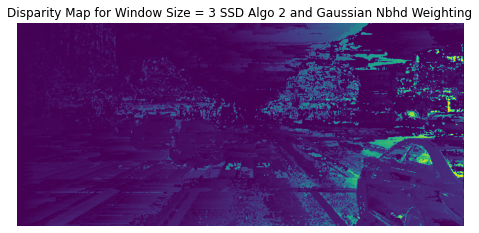

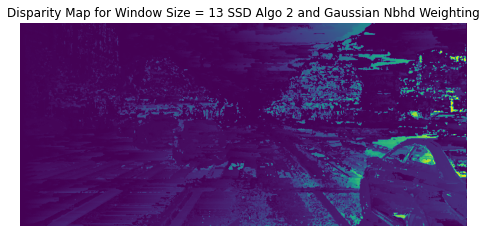

In [50]:
## Loading disparities that were stored in file

img23_disps_ssd_v1 = np.load("img23_disps.npy")

## We need to do this as for the first vectorized implemention as we substracted the left image x from the right image x (of best nbhd)
## (mistake) 
for i in range(0,4):
    img23_disps_ssd_v1[i] = img23_disps_ssd_v1[i]*(-1)

img_23_disps_ssd_v2 = np.load("img23_dispsv3.npy")
img_23_disps_ncc_v2 = np.load("img23_dispsv4ncc.npy")



img_23_disps_ncc_v2_gaus = np.load("img23_dispsv4ncc_gaus.npy")
img_23_disps_ssd_v2_gaus = np.load("img23_dispsv4ssd_gaus.npy")

disp_no_gauss = [img23_disps_ssd_v1,  img_23_disps_ssd_v2 , img_23_disps_ncc_v2] ##

disp_gaus = [img_23_disps_ncc_v2_gaus, img_23_disps_ssd_v2_gaus]


base_path = os.getcwd() ## Make sure you are in the CV_Project Folder
left = cv2.imread(base_path +'/Dataset/2018-07-09-16-11-56_2018-07-09-16-51-40-823-left.jpg')
right = cv2.imread(base_path +'/Dataset/2018-07-09-16-11-56_2018-07-09-16-51-40-823-right.jpg')


plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(left)  
plt.title('Left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(right)  
plt.title('Right image')
plt.axis('off')

plt.show() 

win_sizes = [3,5,9,13]

titles = [" SSD Algo 1", " SSD Algo 2", " NCC Algo 3" ]
title_counter = 0 

for x in disp_no_gauss:

    for i in range(0,4):

        plt.figure(figsize=(8, 8)) 
        plt.title("Disparity Map for Window Size = {}".format(str(win_sizes[i]) + titles[title_counter]))
        plt.axis('off')
        plt.imshow(x[i])
    
    title_counter += 1

gaus_window_sizes = [3,13]
gaus_titles = ["NCC Algo 2", " SSD Algo 2"]

title_counter = 0 

for x in disp_gaus:
    for i in range (0,2):

        plt.figure(figsize=(8, 8)) 
        plt.title("Disparity Map for Window Size = {} and Gaussian Nbhd Weighting".format(str(gaus_window_sizes[i]) + gaus_titles[title_counter]))
        plt.axis('off')
        plt.imshow(x[i])

    title_counter += 1





The results for image 25 and 24 are not displayed below. Also the cells are collapsed. If you want to see them, set market_wants_to_see = True (also expand the cell)

In [47]:
marker_wants_to_see = False ## Set this to true if you want to see results for image 24    

if marker_wants_to_see:

    

    ## Loading disparities that were stored in file
    img24_disps_ssd_v1 = np.load("img24_disps.npy")

    ## We need to do this as for the first vectorized implemention as we substracted the left image x from the right image x (of best nbhd)
    ## (mistake) 
    for i in range(0,4):
        img24_disps_ssd_v1[i] = img24_disps_ssd_v1[i]*(-1)

    img_24_disps_ssd_v2 = np.load("img24_dispsv3.npy")
    img_24_disps_ncc_v2 = np.load("img24_dispsv4ncc.npy")


    disp_no_gauss = [img24_disps_ssd_v1,  img_24_disps_ssd_v2 , img_24_disps_ncc_v2] ##

    base_path = os.getcwd() ## Make sure you are in the CV_Project Folder
    left = cv2.imread(base_path +'/Dataset/2018-07-09-16-11-56_2018-07-09-16-52-31-770-left.jpg')
    right = cv2.imread(base_path +'/Dataset/2018-07-09-16-11-56_2018-07-09-16-52-31-770-right.jpg')
    plt.subplots(figsize=(15, 15)) 

    plt.subplot(1,2,1)
    plt.imshow(left)  
    plt.title('Left image')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(right)  
    plt.title('Right image')
    plt.axis('off')

    plt.show() 

    win_sizes = [3,5,9,13]

    titles = [" SSD Algo 1", " SSD Algo 2", " NCC Algo 3" ]
    title_counter = 0 

    for x in disp_no_gauss:

        for i in range(0,4):

            plt.figure(figsize=(8, 8)) 
            plt.title("Disparity Map for Window Size = {}".format(str(win_sizes[i]) + titles[title_counter]))
            plt.axis('off')
            plt.imshow(x[i])
        
        title_counter += 1



In [46]:
marker_wants_to_see = False ## Set this to true if you want to see results for image 25    

if marker_wants_to_see:

    ## Loading disparities that were stored in file
    img25_disps_ssd_v1 = np.load("img25_disps.npy")

    ## We need to do this as for the first vectorized implemention as we substracted the left image x from the right image x (of best nbhd)
    ## (mistake) 
    for i in range(0,4):
        img25_disps_ssd_v1[i] = img25_disps_ssd_v1[i]*(-1)

    img_25_disps_ssd_v2 = np.load("img25_dispsv3.npy")
    img_25_disps_ncc_v2 = np.load("img25_dispsv4ncc.npy")

    disp_no_gauss = [img25_disps_ssd_v1,  img_25_disps_ssd_v2 , img_25_disps_ncc_v2] ##

    base_path = os.getcwd() ## Make sure you are in the CV_Project Folder
    left = cv2.imread(base_path + '/Dataset/2018-07-09-16-11-56_2018-07-09-16-55-15-689-left.jpg')
    right = cv2.imread(base_path + '/Dataset/2018-07-09-16-11-56_2018-07-09-16-55-15-689-right.jpg')

    plt.subplots(figsize=(15, 15)) 
    plt.subplot(1,2,1)
    plt.imshow(left)  
    plt.title('Left image')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(right)  
    plt.title('Right image')
    plt.axis('off')

    plt.show() 

    win_sizes = [3,5,9,13]

    titles = [" SSD Algo 1", " SSD Algo 2", " NCC Algo 3" ]
    title_counter = 0 

    for x in disp_no_gauss:

        for i in range(0,4):

            plt.figure(figsize=(8, 8)) 
            plt.title("Disparity Map for Window Size = {}".format(str(win_sizes[i]) + titles[title_counter]))
            plt.axis('off')
            plt.imshow(x[i])
        
        title_counter += 1





Statistics for the Results
---

In [24]:
## ARI to fill in . All files should be loaded and ready to go. Remove this comment when done


img_23_disps_ssd_v1 = np.load("img23_disps.npy")

## We need to do this as for the first vectorized implemention as we substracted the left image x from the right image x (of best nbhd)
## (mistake) 
for i in range(0,4):
    img_23_disps_ssd_v1[i] = img_23_disps_ssd_v1[i]*(-1)

img_23_disps_ssd_v2 = np.load("img23_dispsv3.npy")
img_23_disps_ncc_v2 = np.load("img23_dispsv4ncc.npy")


img_23_disps_ncc_v2_gaus = np.load("img23_dispsv4ncc_gaus.npy") ## Gaus was only done for image 23 and window size [3,13]
img_23_disps_ssd_v2_gaus = np.load("img23_dispsv4ssd_gaus.npy")


disp_gaus_img23 = [img_23_disps_ncc_v2_gaus, img_23_disps_ssd_v2_gaus]

img_24_disps_ssd_v1 = np.load("img24_disps.npy")

## We need to do this as for the first vectorized implemention as we substracted the left image x from the right image x (of best nbhd)
## (mistake) 
for i in range(0,4):
    img_24_disps_ssd_v1[i] = img_24_disps_ssd_v1[i]*(-1)

img_24_disps_ssd_v2 = np.load("img24_dispsv3.npy")
img_24_disps_ncc_v2 = np.load("img24_dispsv4ncc.npy")


img_25_disps_ssd_v1 = np.load("img25_disps.npy")

## We need to do this as for the first vectorized implemention as we substracted the left image x from the right image x (of best nbhd)
## (mistake) 
for i in range(0,4):
    img_25_disps_ssd_v1[i] = img_25_disps_ssd_v1[i]*(-1)

img_25_disps_ssd_v2 = np.load("img25_dispsv3.npy")
img_25_disps_ncc_v2 = np.load("img25_dispsv4ncc.npy")




In [25]:
from disparity_stats import get_stats

In [29]:
disparities_for_stats = {}
disparities_for_stats["Version 1"] = {"Image 23": img_23_disps_ssd_v1, 
                                      "Image 24": img_24_disps_ssd_v1,
                                      "Image 25": img_25_disps_ssd_v1}
disparities_for_stats["SSD V2"]    = {"Image 23": img_23_disps_ssd_v2, 
                                      "Image 24": img_24_disps_ssd_v2,
                                      "Image 25": img_25_disps_ssd_v2}
disparities_for_stats["NCC V2"]    = {"Image 23": img_23_disps_ncc_v2, 
                                      "Image 24": img_24_disps_ncc_v2,
                                      "Image 25": img_25_disps_ncc_v2}
disparities_for_stats["Gauss SSD"] = {"Image 23": img_23_disps_ssd_v2_gaus}
disparities_for_stats["Gauss NCC"] = {"Image 23": img_23_disps_ncc_v2_gaus}
ground = {"Image 23": cv2.imread(base_path + '/Dataset/2018-07-09-16-11-56_2018-07-09-16-51-40-823-left.jpg', 0), 
          "Image 24": cv2.imread(base_path + '/Dataset/2018-07-09-16-11-56_2018-07-09-16-52-31-770-left.jpg', 0),
          "Image 25": cv2.imread(base_path + '/Dataset/2018-07-09-16-11-56_2018-07-09-16-55-15-689-left.jpg', 0)}

In [31]:
for version in disparities_for_stats:
    print(version+": ")
    for image in disparities_for_stats[version]:
        print(image+": ")
        if (version[:5]!="Gauss"):
            for disp_calc, size in zip(disparities_for_stats[version][image], [3,5,9,13]):
                print("Window Size "+str(size)+" : ")
                rms, fractions = get_stats(disp_calc, ground[image])
                print("RMS: "+str(rms))
                print(fractions)
        else:
            for disp_calc, size in zip(disparities_for_stats[version][image], [3,13]):
                print("Window Size "+str(size)+" : ")
                rms, fractions = get_stats(disp_calc, ground[image])
                print("RMS: "+str(rms))
                print(fractions)
        print("")

Version 1: 
Image 23: 
Window Size 3 : 
RMS: 187.90580453631384
{4: 0.08435584562996595, 2: 0.039055051078320094, 1: 0.020984676503972757, 0.5: 0.010357548240635641, 0.25: 0.004211123723041998}
Window Size 5 : 
RMS: 161.02229103466965
{4: 0.09436152099886493, 2: 0.042976730987514186, 1: 0.025113507377979568, 0.5: 0.013016458569807038, 0.25: 0.00550794551645857}
Window Size 9 : 
RMS: 122.61510252661311
{4: 0.10106980703745744, 2: 0.04869182746878547, 1: 0.031688422247446085, 0.5: 0.018200908059023836, 0.25: 0.008158342792281498}
Window Size 13 : 
RMS: 102.46801577459442
{4: 0.10690692395005676, 2: 0.05364074914869466, 1: 0.03757094211123723, 0.5: 0.023530079455164585, 0.25: 0.01083144154370034}

Image 24: 
Window Size 3 : 
RMS: 219.53876720859796
{4: 0.110394438138479, 2: 0.07100454029511918, 1: 0.032414869466515325, 0.5: 0.018964245175936437, 0.25: 0.003348467650397276}
Window Size 5 : 
RMS: 201.2683339335027
{4: 0.12732406356413167, 2: 0.08691543700340522, 1: 0.03977582292849035, 0.5:

This shows that Version 2 of the vectorised method combined with SSD and window size 13 gives the best results. We now plot the ground truth disparity map with our disparity map.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


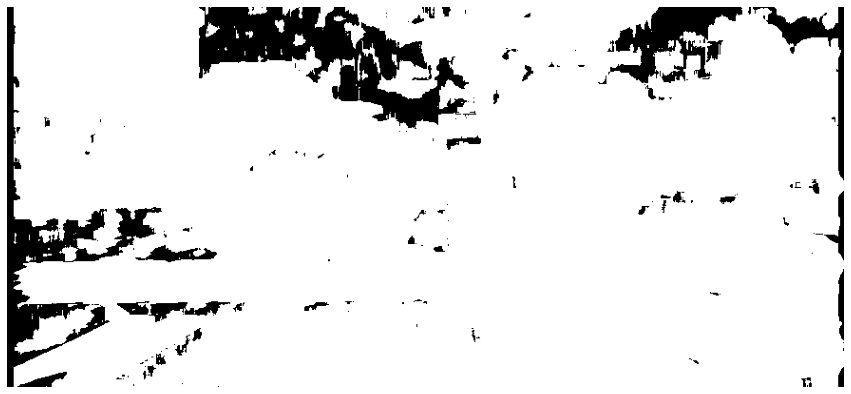

In [52]:
img23__ssd13_v2 = img_23_disps_ssd_v2[3]
img23__ssd13_v2_tran = img23__ssd13_v2*256
img23__ssd13_v2_tran = np.repeat(img23__ssd13_v2_tran, 3)
img23__ssd13_v2_tran = img23__ssd13_v2_tran.reshape(400,881,3)

plt.figure(figsize = (15,15))
# plt.title("Algo 2 Disparity Map for Window Size = 13 with SSD")
plt.axis('off')
plt.imshow(img23__ssd13_v2_tran)

(-0.5, 880.5, 399.5, -0.5)

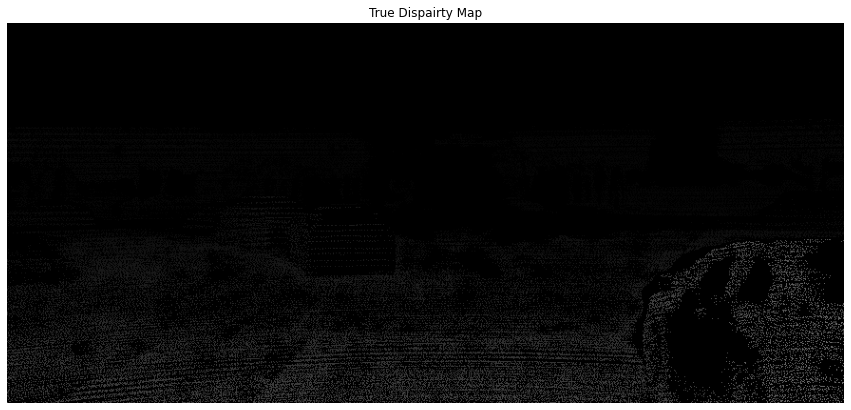

In [54]:
true_disp_23 = cv2.imread(base_path +'/Dataset/2018-07-09-16-11-56_2018-07-09-16-51-40-823-disparity.png')

plt.figure(figsize = (15,15))
plt.imshow(true_disp_23)
plt.title("True Dispairty Map")
plt.axis('off')
